In [144]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [145]:
#Snippet from "naive_model.ipynb". 
#Defining the path and semester
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

## Preprecess Data

In [146]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

### Subject Level DF

In [147]:
#Function from "naive_model.ipynb", extended by me
#Changed to use subject_id
def extract_instance_features(subject_id, early_df):
    instance = pd.DataFrame(data=[subject_id], columns=["SubjectID"])
    early_problems = early_df[early_df["SubjectID"] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    #instance = instance.drop('SubjectID')
    instance['PercLabelledTrue'] = np.mean(early_problems["Label"] == 1)
    try:
        instance['PercAltLabelTrue'] = np.mean(early_problems["alt_Label"] == 1)
    except Exception:
        pass
    return instance


def make_subject_df(task_level_data):
    """Create a DataFrame that aggregates Task-Performance-Data on subject-level

    Args:
        task_level_data (pd.DataFrame): Task-Performance-Date aggregated from Event-Data. 
    """
    subjects = task_level_data["SubjectID"].unique()
    subject_df = pd.DataFrame(columns=["SubjectID", "ProblemsAttempted", "PercCorrectEventually", "MedAttempts", "MaxAttempts", "PercCorrectFirstTry", "PercLabelledTrue", "PercAltLabelTrue"])
    for subject in subjects:
        instance_data = extract_instance_features(subject, task_level_data)
        subject_df = subject_df.append(instance_data)
    return(subject_df)

In [148]:
subject_df = make_subject_df(early)
subject_df

,SubjectID,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry,PercLabelledTrue,PercAltLabelTrue
0,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,30,0.966667,3.0,22,0.333333,0.833333,0.600000
0,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,20,0.750000,4.0,15,0.300000,0.650000,0.450000
0,03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b0...,30,0.966667,3.0,45,0.333333,0.766667,0.533333
0,0461c96c9cc0058f709704605f24136f373ba4e9ac083a...,29,0.896552,6.0,22,0.103448,0.517241,0.310345
0,048fce7bd5670d2ce6215f41856aea059973fb280ce106...,30,1.000000,3.5,26,0.333333,0.833333,0.500000
...,...,...,...,...,...,...,...,...
0,fe545219144abfb405c64d3fed4f32dc348ece7afb0a81...,30,1.000000,2.0,26,0.466667,0.900000,0.600000
0,ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b53...,30,1.000000,4.0,38,0.266667,0.633333,0.433333
0,ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4...,30,0.933333,3.5,34,0.233333,0.800000,0.500000
0,ff86d28801139f82f29ac25c715647674d50977478b8d8...,30,1.000000,3.0,31,0.266667,0.866667,0.633333


### Generate Response matrices

In [149]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U_impute = imputer.fit_transform(U).round()
#U = U.dropna()
U = pd.DataFrame(U_impute).set_index(U.index)
U


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
SubjectID,,,,,,,,,,,,,,,,,,,,,
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
01e96e066eff2e82627dac0493737be2de9bd2f50d6d498bb6420906c7164c05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08b27be1fb7638cc466,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1157d0976f1b6e8419,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
048fce7bd5670d2ce6215f41856aea059973fb280ce1067c7896d7e982dce89a,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814e646ef2f17e69bc7d,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b5381cce52e3ccbcd6b6d,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4aed8f3ccb1962d249f,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [150]:
#Obtain Matrix of Response-vectors
alt_U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["alt_Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
alt_U = alt_U.dropna()
imputer = KNNImputer(n_neighbors=4)
alt_U_impute = imputer.fit_transform(alt_U).round()
#U = U.dropna()
alt_U = pd.DataFrame(alt_U_impute).set_index(alt_U.index)
alt_U

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
SubjectID,,,,,,,,,,,,,,,,,,,,,
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08b27be1fb7638cc466,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
048fce7bd5670d2ce6215f41856aea059973fb280ce1067c7896d7e982dce89a,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048d64d141b976f46d31,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
072db31ce670255297c5d67fd00068faf81a7f50223b5a5af0f555aa69815fe0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814e646ef2f17e69bc7d,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b5381cce52e3ccbcd6b6d,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4aed8f3ccb1962d249f,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [127]:
# ########################################################################
# U = alt_U

In [151]:
from knowledge_growth_model_uirt_lfa import ICC

#Plot all ICC's according to their current parameters
def plot_iccs(a, b, range=[-5,5], step=0.2, title=""):
    for i, discrimination in enumerate(a):
        x = np.arange(start=range[0], stop=range[1], step=step)
        y = ICC([a[i], b[i]], x)
        plt.plot(x,y)
        plt.title(title)

In [152]:
#Obtain Matrix of Response-vectors
late_U = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
late_U_impute = imputer.fit_transform(late_U).round()
#U = U.dropna()
late_U = pd.DataFrame(late_U_impute).set_index(late_U.index)
late_U

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
SubjectID,,,,,,,,,,,,,,,,,,,,
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
01e96e066eff2e82627dac0493737be2de9bd2f50d6d498bb6420906c7164c05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08b27be1fb7638cc466,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1157d0976f1b6e8419,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
048fce7bd5670d2ce6215f41856aea059973fb280ce1067c7896d7e982dce89a,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814e646ef2f17e69bc7d,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b5381cce52e3ccbcd6b6d,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4aed8f3ccb1962d249f,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


### Test Data

In [153]:
TEST_PATH = os.path.join("C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

test_subject_df = make_subject_df(early_test)
test_subject_df = test_subject_df.drop("PercAltLabelTrue", 1)

#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")
imputer = KNNImputer(n_neighbors=4)
test_U_impute = imputer.fit_transform(test_U).round()
#U = U.dropna()
test_U = pd.DataFrame(test_U_impute).set_index(test_U.index)

#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#test_U = test_U.fillna(test_U.median())
miss_indices_early = np.where(np.isnan(test_U.to_numpy().flatten()))

#Obtain Matrix of Response-vectors
test_late_U = pd.crosstab(index = late_test["SubjectID"], 
            columns=[late_test["AssignmentID"], late_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#test_U = test_U.fillna(test_U.median())
miss_indices_late = np.where(np.isnan(test_late_U.to_numpy().flatten()))
miss_indices_late

(array([ 365,  366,  367,  368,  369,  400,  401,  402,  403,  404,  405,
         406,  407,  408,  409,  559,  770,  771,  772,  773,  774,  775,
         776,  777,  778,  779,  915, 1038, 1277, 1279, 1460, 1461, 1462,
        1463, 1464, 1465, 1466, 1467, 1468, 1469, 1474, 1475, 1476, 1478,
        1479, 1787, 1788, 1799, 1955, 1959, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2072, 2074, 2075, 2076, 2077,
        2078, 2079, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118,
        2119, 2305, 2306, 2307, 2308, 2317, 2318, 2319, 2350, 2351, 2352,
        2353, 2354, 2355, 2356, 2357, 2358, 2359], dtype=int64),)

## Use new Model Module for standard MMLE EM-Algorithm

In [154]:
from importlib import reload
import knowledge_growth_model_uirt_lfa 
reload(knowledge_growth_model_uirt_lfa)

model = knowledge_growth_model_uirt_lfa.knowledge_growth_model()
model.fit(early_response_data=U, late_response_data=late_U, alpha_k=15, s_k=15)

Fit early Item Parameters:
Step: 1: current parameter_diff: [13.879891568475276, 31.56609670519229], current data likelihood: 36268.21155681333
Step: 2: current parameter_diff: [3.177409466349168, 7.169748327604463], current data likelihood: 36420.146960192855
Step: 3: current parameter_diff: [1.9710455252104069, 8.394324938358832], current data likelihood: 36517.94025846824
Step: 4: current parameter_diff: [1.2917827810517235, 8.50307233446799], current data likelihood: 36583.08525024435
Step: 5: current parameter_diff: [0.8590642380548462, 7.975780624136481], current data likelihood: 36643.0127723582
Step: 6: current parameter_diff: [0.5980283305786478, 7.149046658367626], current data likelihood: 36704.004038206345
Step: 7: current parameter_diff: [0.4298379880397069, 6.237924775761486], current data likelihood: 36766.996367658205
Step: 8: current parameter_diff: [0.31931485455534636, 5.363889100954834], current data likelihood: 36830.900934305435
Step: 9: current parameter_diff: [0

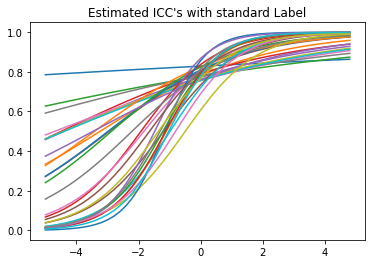

In [155]:
#ICC's for EM-Result with standard Label
a_hat= model.a_hat
b_hat = model.b_hat

plot_iccs(a_hat, b_hat, range=[-5, 5], title="Estimated ICC's with standard Label")

### Predict Answers

#### Train

In [156]:
pred_train = np.squeeze(model.predict_answers(U))
p_train = model.predict_answers(U, return_p=True)

In [157]:
model.get_training_performance(U, late_U)

Accuracy per Question: 
[0.80108992 0.77929155 0.81743869 0.73569482 0.7520436  0.74114441
 0.73024523 0.72207084 0.77111717 0.69209809 0.76021798 0.80381471
 0.72479564 0.74114441 0.80381471 0.72479564 0.6893733  0.72207084
 0.7493188  0.75749319] 
Overall acuracy: 0.7509536784741144
AUC-Score: 0.7448678771115869


## Model simple regression on s

In [158]:
from sklearn.preprocessing import normalize

pred_index = late_U.index

U_split = U.reindex(late_U.index).fillna(U.mean()).to_numpy()
subject_df_split = subject_df.set_index(subject_df["SubjectID"]).reindex(pred_index).drop("SubjectID", axis=1).drop("PercAltLabelTrue", axis=1).astype("float32").to_numpy()
#code_embeddings_split = normalize(code_embeddings.reindex(pred_index).fillna(code_embeddings.mean()).to_numpy())
alpha_split = pd.DataFrame(model.alpha).set_index(U.index).reindex(pred_index).fillna(np.nanmean(model.alpha))
late_U_split = late_U.to_numpy()
s_split = pd.DataFrame(model.s_hat).set_index(late_U.index).reindex(pred_index)

In [159]:
from sklearn.model_selection import train_test_split


index_train, index_val, U_train, U_val, subject_df_train, subject_df_val, alpha_train, alpha_val, late_U_train, late_U_val, s_train, s_val = \
train_test_split(pred_index,
                  U_split,
                  subject_df_split,
                  alpha_split,
                  late_U_split,
                  s_split
                  )

(array([  2.,   9.,  23.,  19.,  34.,  25.,  47.,  32.,  56., 120.]),
 array([-0.53420399, -0.09334937,  0.34750526,  0.78835988,  1.22921451,
         1.67006913,  2.11092375,  2.55177838,  2.992633  ,  3.43348763,
         3.87434225]),
 <BarContainer object of 10 artists>)

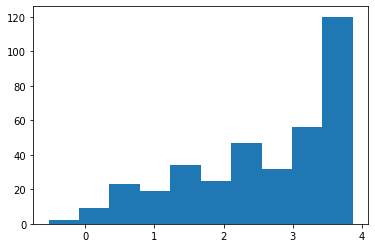

In [160]:
plt.hist(model.s_hat)

In [161]:
late_subject_df = subject_df.set_index(subject_df["SubjectID"]).reindex(late_U.index).drop("SubjectID", 1)
late_subject_df["s_hat"] = s_split
late_subject_df["alpha"] = alpha_split
late_subject_df

,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry,PercLabelledTrue,PercAltLabelTrue,s_hat,alpha
SubjectID,,,,,,,,,
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,30,0.966667,3.0,22,0.333333,0.833333,0.600000,2.222724,-0.135328
01e96e066eff2e82627dac0493737be2de9bd2f50d6d498bb6420906c7164c05,20,0.750000,4.0,15,0.300000,0.650000,0.450000,1.594034,-1.017710
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08b27be1fb7638cc466,30,0.966667,3.0,45,0.333333,0.766667,0.533333,1.561463,-0.423944
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1157d0976f1b6e8419,29,0.896552,6.0,22,0.103448,0.517241,0.310345,0.646409,-1.665064
048fce7bd5670d2ce6215f41856aea059973fb280ce1067c7896d7e982dce89a,30,1.000000,3.5,26,0.333333,0.833333,0.500000,3.810996,0.617596
...,...,...,...,...,...,...,...,...,...
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814e646ef2f17e69bc7d,30,1.000000,2.0,26,0.466667,0.900000,0.600000,3.810975,0.574694
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b5381cce52e3ccbcd6b6d,30,1.000000,4.0,38,0.266667,0.633333,0.433333,2.376280,-0.760643
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4aed8f3ccb1962d249f,30,0.933333,3.5,34,0.233333,0.800000,0.500000,3.132287,0.557913


In [162]:
late_subject_df.corr()

,PercCorrectEventually,MedAttempts,PercCorrectFirstTry,PercLabelledTrue,PercAltLabelTrue,s_hat,alpha
PercCorrectEventually,1.000000,-0.258588,0.214978,0.592129,0.438580,0.199988,0.578939
MedAttempts,-0.258588,1.000000,-0.728871,-0.808329,-0.834343,-0.514287,-0.785030
PercCorrectFirstTry,0.214978,-0.728871,1.000000,0.667328,0.851903,0.519973,0.718496
PercLabelledTrue,0.592129,-0.808329,0.667328,1.000000,0.883173,0.486866,0.920141
PercAltLabelTrue,0.438580,-0.834343,0.851903,0.883173,1.000000,0.533642,0.870380
s_hat,0.199988,-0.514287,0.519973,0.486866,0.533642,1.000000,0.602418
alpha,0.578939,-0.785030,0.718496,0.920141,0.870380,0.602418,1.000000


In [163]:
from sklearn.linear_model import LinearRegression

def linear_regression(X, Y):   
    clf = LinearRegression()
    clf.fit(X, Y)
    R2 = clf.score(X, Y)
    intercept = np.round(clf.intercept_, 2).tolist()[0]
    coeffs = np.round(clf.coef_, 2).tolist()[0]
    print("Linear Equation: Y = {0} + {1}".format(intercept, " + ".join(["{0}*X_{1}".format(coeff, i) for i, coeff in enumerate(coeffs)])))
    print("R2: {0}".format(R2))
    return(clf)

print("Only alpha:")
clf = linear_regression(late_subject_df["alpha"].to_numpy().reshape(-1,1), late_subject_df["s_hat"].to_numpy().reshape(-1,1))

print("\nalpha and PercCorrectFirstTry")
clf = linear_regression(late_subject_df[["alpha", "PercCorrectFirstTry"]].to_numpy().reshape(-1,2), late_subject_df["s_hat"].to_numpy().reshape(-1,1))

print("\nalpha and MedAttempts")
clf = linear_regression(late_subject_df[["alpha", "MedAttempts"]].to_numpy().reshape(-1,2), late_subject_df["s_hat"].to_numpy().reshape(-1,1))


Only alpha:
Linear Equation: Y = 2.7 + 0.64*X_0
R2: 0.36290715381449934

alpha and PercCorrectFirstTry
Linear Equation: Y = 2.37 + 0.5*X_0 + 0.96*X_1
R2: 0.37860298322367414

alpha and MedAttempts
Linear Equation: Y = 2.88 + 0.55*X_0 + -0.06*X_1
R2: 0.36736750606873203


In [164]:

def cutoff_predict(X, cutoffs, values):
    pred = np.empty(shape=X.shape)
    for i in range(0, len(cutoffs)+1):
        if i==0:
            lower_cutoff = np.min(X)
            higher_cutoff = cutoffs[i]
        elif i==len(cutoffs):
            lower_cutoff = cutoffs[i-1]
            higher_cutoff = np.max(X)
        else:
            lower_cutoff = cutoffs[i-1]
            higher_cutoff = cutoffs[i]
        pred[np.where((X <= higher_cutoff) & (X > lower_cutoff))[0]] = values[i]
    return(pred)

def cutoff_cluster_regression(X, Y, n_cutoffs=2, iter=100000, loss=lambda x, y: np.mean(np.square(x-y)), value_function=lambda x: np.mean(x)):
    #loss = lambda x, y: np.mean(np.square(x-y))
    min_x = np.min(X)
    max_x = np.max(X)
    min_loss = float("inf")
    for i in range(0, iter):
        cutoffs = np.random.uniform(min_x, max_x, size=n_cutoffs).tolist()
        Y_parts = []
        X_copy = X.copy()
        for i in range(0, n_cutoffs+1):
            if i < n_cutoffs:
                Y_part_index = np.where(X_copy<=cutoffs[i])[0]
            else: 
                Y_part_index = np.where(X_copy <= np.max(X))[0]
            Y_parts.append(Y[Y_part_index])
            X_copy = X[1 - Y_part_index]
        Y_means = [value_function(part) for part in Y_parts]
        pred = cutoff_predict(X, cutoffs, Y_means)
        current_loss = loss(pred, Y)
        if current_loss < min_loss:
            min_loss = current_loss
            values = Y_means
            best_cutoffs = cutoffs
    return(best_cutoffs, values, min_loss)

In [165]:
cutoff_regress = cutoff_cluster_regression(late_subject_df["alpha"].to_numpy(), late_subject_df["s_hat"].to_numpy(), n_cutoffs=1)[0:2]
s_pred_cutoff = cutoff_predict(late_subject_df["alpha"].to_numpy(), *cutoff_regress)

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4120\3482170237.py:16: RuntimeWarning: overflow encountered in square
  def cutoff_cluster_regression(X, Y, n_cutoffs=2, iter=100000, loss=lambda x, y: np.mean(np.square(x-y)), value_function=lambda x: np.mean(x)):


In [166]:
auc_loss = lambda s, Y: -1*model.get_training_performance(pd.DataFrame(U_split, columns=U.columns).set_index(pred_index), \
                                     pd.DataFrame(late_U_split, columns=late_U.columns).set_index(pred_index), s, return_performance=True)["AUC"]

random_value = lambda x: np.random.uniform(low=np.min(x), high=np.max(x))

cutoff_regress = cutoff_cluster_regression(late_subject_df["alpha"].to_numpy(), late_subject_df["s_hat"].to_numpy(), n_cutoffs=1, iter=70, loss=auc_loss, value_function=random_value)[0:2]
s_pred_cutoff = cutoff_predict(late_subject_df["alpha"].to_numpy(), *cutoff_regress)
s_pred_cutoff_val = cutoff_predict(late_subject_df["alpha"][index_val].to_numpy(), *cutoff_regress)

Accuracy per Question: 
[0.78746594 0.78474114 0.81743869 0.73569482 0.74659401 0.74114441
 0.73024523 0.71934605 0.77111717 0.6866485  0.76021798 0.79836512
 0.72479564 0.73841962 0.82833787 0.72479564 0.69482289 0.72752044
 0.73297003 0.77656676] 
Overall acuracy: 0.7513623978201635
AUC-Score: 0.743960395613409
Accuracy per Question: 
[0.80926431 0.7493188  0.80108992 0.66212534 0.66485014 0.69482289
 0.64305177 0.61307902 0.67302452 0.6239782  0.71117166 0.6893733
 0.60217984 0.65940054 0.79836512 0.56675749 0.46321526 0.61307902
 0.60217984 0.58855586] 
Overall acuracy: 0.6614441416893733
AUC-Score: 0.7322895339481824
Accuracy per Question: 
[0.80653951 0.79291553 0.77384196 0.73841962 0.74386921 0.73841962
 0.72479564 0.72752044 0.75476839 0.67029973 0.77111717 0.79836512
 0.72479564 0.76021798 0.79564033 0.74659401 0.70844687 0.73841962
 0.74659401 0.75476839] 
Overall acuracy: 0.750817438692098
AUC-Score: 0.7426311641434064
Accuracy per Question: 
[0.80653951 0.77929155 0.809264

Accuracy per Question: 
[0.80653951 0.77929155 0.80653951 0.72752044 0.72752044 0.71662125
 0.70027248 0.71117166 0.74659401 0.65122616 0.7520436  0.77384196
 0.70027248 0.73297003 0.79291553 0.6893733  0.64850136 0.6866485
 0.71389646 0.69754768] 
Overall acuracy: 0.7280653950953678
AUC-Score: 0.7438569881162578
Accuracy per Question: 
[0.80653951 0.77929155 0.80926431 0.73297003 0.73024523 0.71662125
 0.70027248 0.71117166 0.74659401 0.65395095 0.75476839 0.76839237
 0.70299728 0.73569482 0.79564033 0.70027248 0.65395095 0.69209809
 0.72752044 0.69754768] 
Overall acuracy: 0.7307901907356948
AUC-Score: 0.7440318123332958
Accuracy per Question: 
[0.80653951 0.77929155 0.80926431 0.73569482 0.73297003 0.71389646
 0.70299728 0.71389646 0.74659401 0.65667575 0.75476839 0.77929155
 0.71117166 0.74114441 0.79564033 0.70572207 0.65395095 0.6866485
 0.72207084 0.70299728] 
Overall acuracy: 0.7325613079019073
AUC-Score: 0.7441665257898493
Accuracy per Question: 
[0.80653951 0.77929155 0.80926

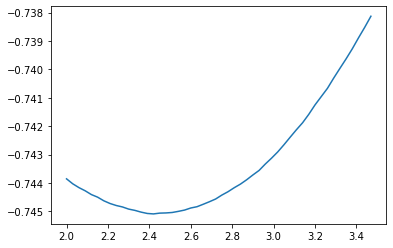

In [167]:
alpha_range = np.arange(2,3.5, step=0.03)
auc_values = [auc_loss(i*np.ones(len(pred_index)), None) for i in alpha_range]

plt.plot(alpha_range, auc_values)

In [168]:
np.mean(s_split)

0    2.604619
dtype: float64

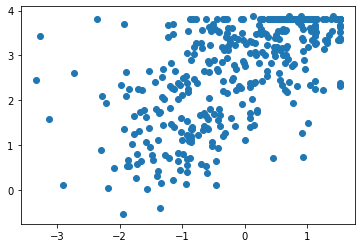

In [169]:
plt.scatter(late_subject_df["alpha"].to_numpy(), late_subject_df["s_hat"].to_numpy())

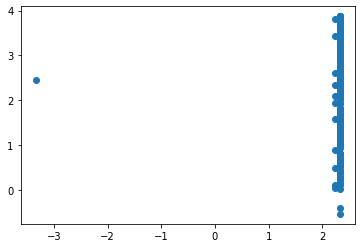

In [170]:
plt.scatter(s_pred_cutoff, late_subject_df["s_hat"].to_numpy())

In [171]:
clf = linear_regression(late_subject_df[["alpha", "PercCorrectFirstTry"]].to_numpy().reshape(-1,2), late_subject_df["s_hat"].to_numpy().reshape(-1,1))

s_pred = clf.predict(late_subject_df[["alpha", "PercCorrectFirstTry"]].to_numpy().reshape(-1,2))
s_pred_val = clf.predict(late_subject_df[["alpha", "PercCorrectFirstTry"]].loc[index_val,:].to_numpy().reshape(-1,2))

Linear Equation: Y = 2.37 + 0.5*X_0 + 0.96*X_1
R2: 0.37860298322367414


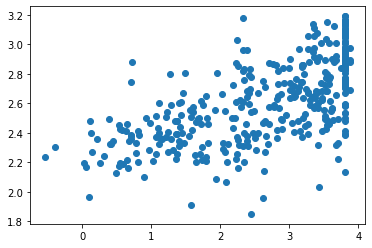

In [172]:
plt.scatter(s_split, np.add(0.4*s_pred,0.6*np.mean(s_split)[0]))

In [180]:
print("\nPerformance of Regression Model:")
#Model with neural Network
model.get_training_performance(pd.DataFrame(U_split, columns=U.columns), pd.DataFrame(late_U_split, columns=late_U.columns), s_pred.transpose()[0])

print("\nPerformance of Mixed Model:")
#Model with neural Network
model.get_training_performance(pd.DataFrame(U_split, columns=U.columns), pd.DataFrame(late_U_split, columns=late_U.columns), np.add(0.7*s_pred,0.3*np.mean(s_split)[0]).transpose()[0])

print("\nPerformance of Model with mean S")
#Model with naive s (Mean)
model.get_training_performance(pd.DataFrame(U_split, columns=U.columns), pd.DataFrame(late_U_split, columns=late_U.columns))

print("\nPerformance of Model with Median S")
#Model with naive s (Mean)
model.get_training_performance(pd.DataFrame(U_split, columns=U.columns), pd.DataFrame(late_U_split, columns=late_U.columns), np.median(s_split)*np.ones(shape=U_split.shape[0]))

print("\nPerformance of Model with Cutoff S")
model.get_training_performance(pd.DataFrame(U_split, columns=U.columns).set_index(pred_index), pd.DataFrame(late_U_split, columns=late_U.columns).set_index(pred_index), s_pred_cutoff)

print("\nPerformance of Model with estimated Practise amount:")
#Model with real s_hat values
s_hat_reindex = pd.DataFrame(model.s_hat).set_index(late_U.index).reindex(U.index)
model.get_training_performance(U, late_U, s_hat_reindex.to_numpy().transpose()[0])


Performance of Regression Model:
Accuracy per Question: 
[0.80381471 0.77929155 0.80108992 0.74114441 0.73569482 0.71662125
 0.71662125 0.71662125 0.74659401 0.67847411 0.76021798 0.77384196
 0.71389646 0.74386921 0.80108992 0.70299728 0.6893733  0.69482289
 0.73297003 0.71389646] 
Overall acuracy: 0.7381471389645777
AUC-Score: 0.7463390615412551

Performance of Mixed Model:
Accuracy per Question: 
[0.80653951 0.77929155 0.80926431 0.73841962 0.74659401 0.72752044
 0.71662125 0.71662125 0.76566757 0.67847411 0.75749319 0.78474114
 0.70844687 0.75476839 0.79019074 0.70572207 0.69482289 0.69754768
 0.73841962 0.71934605] 
Overall acuracy: 0.7418256130790191
AUC-Score: 0.7463365179320536

Performance of Model with mean S
Accuracy per Question: 
[0.80108992 0.77929155 0.81743869 0.73569482 0.7520436  0.74114441
 0.73024523 0.72207084 0.77111717 0.69209809 0.76021798 0.80381471
 0.72479564 0.74114441 0.80381471 0.72479564 0.6893733  0.72207084
 0.7493188  0.75749319] 
Overall acuracy: 0.75

In [181]:
print("\nPerformance of Regression Model:")
#Model with neural Network
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns), pd.DataFrame(late_U_val, columns=late_U.columns), s_pred_val.transpose()[0])

print("\nPerformance of Mixed Model:")
#Model with neural Network
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns), pd.DataFrame(late_U_val, columns=late_U.columns), np.add(0.7*s_pred_val,0.3*np.mean(s_split)[0]).transpose()[0])

print("\nPerformance of Model with mean S")
#Model with naive s (Mean)
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns), pd.DataFrame(late_U_val, columns=late_U.columns))

print("\nPerformance of Model with Median S")
#Model with naive s (Mean)
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns), pd.DataFrame(late_U_val, columns=late_U.columns), np.median(s_split)*np.ones(shape=U_val.shape[0]))

print("\nPerformance of Model with Cutoff S")
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns).set_index(index_val), pd.DataFrame(late_U_val, columns=late_U.columns).set_index(index_val), s_pred_cutoff_val)

print("\nPerformance of Model with estimated Practise amount:")
#Model with real s_hat values
s_hat_reindex = pd.DataFrame(model.s_hat).set_index(late_U.index).loc[index_val,:].reindex(index_val)
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns).set_index(index_val), pd.DataFrame(late_U_val, columns=late_U.columns).set_index(index_val), s_hat_reindex.to_numpy().transpose()[0])


Performance of Regression Model:
Accuracy per Question: 
[0.77173913 0.77173913 0.7826087  0.7173913  0.64130435 0.67391304
 0.73913043 0.63043478 0.76086957 0.61956522 0.73913043 0.75
 0.72826087 0.79347826 0.73913043 0.73913043 0.69565217 0.66304348
 0.67391304 0.68478261] 
Overall acuracy: 0.7157608695652173
AUC-Score: 0.7248291362781523

Performance of Mixed Model:
Accuracy per Question: 
[0.7826087  0.7826087  0.79347826 0.7173913  0.66304348 0.66304348
 0.73913043 0.63043478 0.77173913 0.61956522 0.69565217 0.77173913
 0.70652174 0.80434783 0.75       0.73913043 0.69565217 0.66304348
 0.67391304 0.69565217] 
Overall acuracy: 0.7179347826086957
AUC-Score: 0.7248631684548354

Performance of Model with mean S
Accuracy per Question: 
[0.7826087  0.76086957 0.79347826 0.67391304 0.68478261 0.69565217
 0.73913043 0.65217391 0.77173913 0.64130435 0.69565217 0.81521739
 0.70652174 0.7826087  0.75       0.77173913 0.68478261 0.68478261
 0.68478261 0.76086957] 
Overall acuracy: 0.72663043

## Predict on Test Data

In [175]:
test_alpha = model.predict_early_ability(test_U)
test_subject_df.index = test_subject_df["SubjectID"]
test_subject_df = test_subject_df.drop("SubjectID", 1)
test_subject_df["alpha"] = test_alpha

In [176]:
s_test_pred = clf.predict(test_subject_df[["alpha", "PercCorrectFirstTry"]].to_numpy().reshape(-1,2)) + 0.5*np.mean(model.s_hat)

In [179]:
s_test_pred = clf.predict(test_subject_df[["alpha", "PercCorrectFirstTry"]].to_numpy().reshape(-1,2))
#s_test_pred = clf.predict(test_subject_df[["alpha", "PercCorrectFirstTry"]].to_numpy().reshape(-1,2)) + 0.5*np.mean(model.s_hat)
p_test = model.predict_answers(test_U, s_test_pred.flatten(), return_p=True).to_numpy()

late_test["Label"] = np.delete(p_test.reshape((np.prod(p_test.shape),1)), miss_indices_late)
late_test

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.858522
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.845834
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.890313
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.827873
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.830916
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.046257
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.023650
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.061935
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.054406


In [178]:
late_test[["SubjectID", "AssignmentID", "ProblemID", "Label"]].to_csv("C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/submissions/predictions.csv", header=True)